In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import pymultinest as pmn
import sys
import pandas as pd
import corner

from astropy.coordinates import SkyCoord
from utils_func import vincenty_sep
from scipy.stats import pearsonr

In [4]:
# load SN data
varnames = np.loadtxt('Pantheon/data_fitres/Ancillary_G10.FITRES', skiprows=6, dtype=str)[0]
data_SN = np.loadtxt('Pantheon/data_fitres/Ancillary_G10.FITRES', skiprows=7, dtype=str)
num_SN = len(data_SN)
sys_SN = np.loadtxt('Pantheon/data_fitres/sys_full_long_G10.txt', skiprows=1).reshape(num_SN, num_SN)



In [3]:
#reorganise the data to fit 
print(varnames)
mu_SN = data_SN[:,np.where(varnames == "MU")[0][0]].astype('float32')
sigma_SN = data_SN[:,np.where(varnames == "MUERR")[0][0]].astype('float32')
zCMB_SN = data_SN[:,np.where(varnames == "zCMB")[0][0]].astype('float32')
zHD_SN = data_SN[:,np.where(varnames == "zHD")[0][0]].astype('float32')

RA_SN = data_SN[:,np.where(varnames == "RA")[0][0]].astype('float32')
Dec_SN = data_SN[:,np.where(varnames == "DECL")[0][0]].astype('float32')

c_SN = np.diag(sigma_SN**2.) + sys_SN
cinv_SN = np.linalg.inv(c_SN)

['VARNAMES:' 'CID' 'CIDint' 'IDSURVEY' 'TYPE' 'FIELD' 'CUTFLAG_SNANA'
 'zCMB' 'zCMBERR' 'zHD' 'zHDERR' 'VPEC' 'VPEC_ERR' 'HOST_LOGMASS'
 'HOST_LOGMASS_ERR' 'SNRMAX1' 'SNRMAX2' 'SNRMAX3' 'PKMJD' 'PKMJDERR' 'x1'
 'x1ERR' 'c' 'cERR' 'mB' 'mBERR' 'x0' 'x0ERR' 'COV_x1_c' 'COV_x1_x0'
 'COV_c_x0' 'NDOF' 'FITCHI2' 'FITPROB' 'RA' 'DECL' 'TGAPMAX' 'TrestMIN'
 'TrestMAX' 'MWEBV' 'MU' 'MUMODEL' 'MUERR' 'MUERR_RAW' 'MURES' 'MUPULL'
 'ERRCODE' 'biasCor_mu' 'biasCorErr_mu' 'biasCor_mB' 'biasCor_x1'
 'biasCor_c' 'biasScale_muCOV' 'IDSAMPLE']


In [6]:
def vincenty_sep(lon1, lat1, lon2, lat2):
    """
    Get the on sky separation using Vincenty's formula for the SN - CMB distance
    Transcribed from the astropy formula. Also available at:

    https://en.wikipedia.org/wiki/Great-circle_distance
    """
    sdlon = np.sin(lon2 - lon1)
    cdlon = np.cos(lon2 - lon1)
    slat1 = np.sin(lat1)
    slat2 = np.sin(lat2)
    clat1 = np.cos(lat1)
    clat2 = np.cos(lat2)

    num1 = clat2 * sdlon
    num2 = clat1 * slat2 - slat1 * clat2 * cdlon

    denominator = slat1 * slat2 + clat1 * clat2 * cdlon
    return np.arctan2(np.hypot(num1, num2), denominator)


In [7]:
cc = SkyCoord(RA_SN, Dec_SN, unit="deg", frame="icrs").galactic
sep = vincenty_sep(cc.l.deg * np.pi/180., cc.b.deg * np.pi/180., 264 * np.pi/180., 48.5 * np.pi/180.)
frac_sep = np.cos(sep)
print(min(frac_sep))

-0.9998704426430897


In [8]:
c = 299792.458 #in km/s

def dl_q0aniso(z, h0, q0, qd, j0, ra, dec, lcmb = 264.021, bcmb = 48.523):
    """
    Written as one massive be-all function with the (l,b) from the CMB fixed
    """    
    coords = SkyCoord(ra, dec, frame='icrs', unit="deg")
    gal_coords = coords.galactic
    
    sep = vincenty_sep(gal_coords.l.deg * np.pi/180., gal_coords.b.deg * np.pi/180., lcmb * np.pi/180., bcmb * np.pi/180.)
    
    q = q0 + qd * np.cos(sep)
    term = 1 + (1 - q) * z / 2. - (1 - q - 3*q**2. + j0)  * z ** 2. / 6.
    
    dl = (c * z ) * term/h0
    return dl

In [ ]:
def llhood(model_param, ndim, npar):
    h0, q0, qd, j0, M = [model_param[i] for i in range(5)]
    dl_aniso = dl_q0aniso(zCMB_SN, h0, q0, qd, j0, RA_SN, Dec_SN)
    mu_th = 5*np.log10(dl_aniso) + 25.
    delta1 = mu_SN - mu_th + M 
    chisq = np.dot(delta1.T, np.dot(cinv_SN, delta1))
    return -0.5*chisq

def prior(cube, ndim, npar):
    cube[0] = cube[0] * 50. + 50.
    cube[1] = cube[1] * 8. - 4.
    cube[2] = cube[2] * 20. - 10.
    cube[3] = cube[3] * 20. - 10.
    cube[4] = cube[4] * 4. - 2.
    
pmn.run(llhood, prior, 5, verbose=True, n_live_points=150, outputfiles_basename='chains/q0aniso_test-')

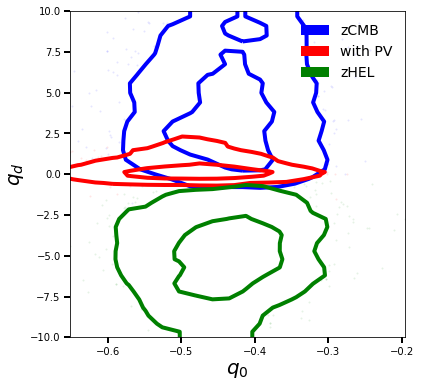

In [15]:
#load the samples for the contours
cmb = np.loadtxt('chains/q0aniso_test_cmb_exp-post_equal_weights.dat')
hd = np.loadtxt('chains/q0aniso_test_hd_exp-post_equal_weights.dat')
hel = np.loadtxt('chains/q0aniso_test_hel_exp-post_equal_weights.dat')
plt.figure(1, figsize=(6, 6))
corner.hist2d(cmb[:,1], cmb[:,2], smooth=1, levels=(1-np.exp(-0.5), 1-np.exp(-2)), color='b', plot_density=False, 
              contour_kwargs={'linewidths':4})
corner.hist2d(hd[:,1], hd[:,2], smooth=1, levels=(1-np.exp(-0.5), 1-np.exp(-2)), color='r', plot_density=False, 
              contour_kwargs={'linewidths':4})
corner.hist2d(hel[:,1], hel[:,2], smooth=1, levels=(1-np.exp(-0.5), 1-np.exp(-2)), color='g', plot_density=False, 
              contour_kwargs={'linewidths':4})
plt.hist([], color='b', label='zCMB')
plt.hist([], color='r', label='with PV')
plt.hist([], color='g', label='zHEL')
plt.ylim(-10, 10)
plt.tick_params(length=6, width=2, labelsize=10)
plt.legend(loc=0, frameon=False, prop={'size':14})
plt.ylabel('$q_d$', fontsize=20)
plt.xlabel('$q_0$', fontsize=20)
plt.savefig('plots/contour/q0_dipole_Exp_zCMBHDHel.png')

## Hereafter the plots and values are focussed on the JLA results

In [13]:
fid = np.loadtxt('chains/q0aniso_test_JLA_cmb_exp_withPVCovSigZ_FidNoBiasSub_lp250-post_equal_weights.dat')
print("qm is", round(np.median(fid[:,1]), 4), "$\pm$", round(np.std(fid[:,1]), 4))
print("qd is", round(np.median(fid[:,2]), 4), "$\pm$", round(np.std(fid[:,2]), 4))
print("j0 - ok is", round(np.median(fid[:,3]),4), "$\pm$", round(np.std(fid[:,3]), 4))
print("S is", round(np.median(fid[:,8]), 4), "$\pm$", round(np.std(fid[:,8]), 4))
print("Pearson coefficient between monopole and dipole", pearsonr(fid[:,1], fid[:,2]))

qm is -0.3535 $\pm$ 0.11
qd is 0.9335 $\pm$ 3.0817
j0 - ok is -0.2681 $\pm$ 0.4583
S is 0.0353 $\pm$ 0.3548
Pearson coefficient between monopole and dipole (-0.18498497077548787, 8.22730208445093e-16)


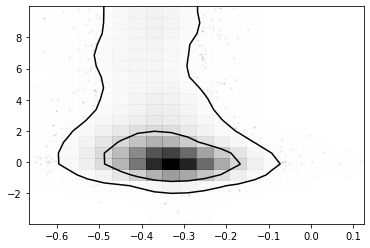

In [15]:
import corner
corner.hist2d(fid[:,1], fid[:,2], smooth=1, levels=(1-np.exp(-0.5), 1 - np.exp(-2)))

In [16]:
fid_hel = np.loadtxt('chains/q0aniso_test_JLA_hel_exp_withPVCovSigZ-post_equal_weights.dat')
print("qm is", round(np.median(fid_hel[:,1]), 4), "$\pm$", round(np.std(fid_hel[:,1]), 4))
print("qd is", round(np.median(fid_hel[:,2]), 4), "$\pm$", round(np.std(fid_hel[:,2]), 4))
print("j0 - ok is", round(np.median(fid_hel[:,3]),4), "$\pm$", round(np.std(fid_hel[:,3]), 4))
print("S is", round(np.median(fid_hel[:,8]), 4), "$\pm$", round(np.std(fid_hel[:,8]), 4))
print("Pearson coefficient between monopole and dipole", pearsonr(fid_hel[:,1], fid_hel[:,2]))


qm is -0.3828 $\pm$ 0.1122
qd is -0.1264 $\pm$ 0.7904
j0 - ok is -0.1622 $\pm$ 0.4987
S is 0.1265 $\pm$ 0.445
Pearson coefficient between monopole and dipole (-0.11154556122981672, 0.0008237039014999269)


## Forecast plots with Pantheon

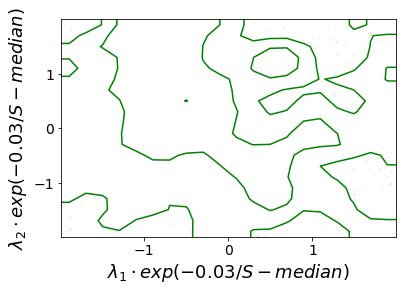

In [16]:
dd = np.loadtxt('chains/sims/q0aniso_sims_quad_exp_iso_trueCoord_LCDM_0_stat_only_lp200-post_equal_weights.dat')
dd3 = np.loadtxt('chains/sims/q0aniso_sims_quad_exp_iso_trueCoord_LCDM_2_stat_only_lp200-post_equal_weights.dat')
dd5 = np.loadtxt('chains/sims/q0aniso_sims_quad_exp_iso_trueCoord_LCDM_4_stat_only_lp200-post_equal_weights.dat')
dd10 = np.loadtxt('chains/sims/q0aniso_sims_quad_exp_iso_trueCoord_LCDM_9_stat_only_lp200-post_equal_weights.dat')


fac = np.exp(-0.03 / np.median(dd[:,-2]))
fac3 = np.exp(-0.03 / np.median(dd3[:,-2]))
fac5 = np.exp(-0.03 / np.median(dd5[:,-2]))



#corner.hist2d(dd5[:,-4] * fac5, dd5[:,-3] * fac5, smooth=1, levels=(1-np.exp(-0.5), 1 - np.exp(-2)), plot_density=False, color='b')
#corner.hist2d(dd[:,-4] * fac, dd[:,-3] * fac, smooth=1, levels=(1-np.exp(-0.5), 1 - np.exp(-2)), plot_density=False, color='g')

#corner.hist2d(dd3[:,-4] * fac3, dd3[:,-3] * fac3, smooth=1, levels=(1-np.exp(-0.5), 1 - np.exp(-2)), plot_density=False, color='r')
#corner.hist2d(dd3[:,-4], dd3[:,-3], smooth=1, levels=(1-np.exp(-0.5), 1 - np.exp(-2)), plot_density=False, color='r')
#corner.hist2d(dd[:,-4], dd[:,-3], smooth=1, levels=(1-np.exp(-0.5), 1 - np.exp(-2)), plot_density=False, color='g')
corner.hist2d(dd10[:,-4], dd10[:,-3], smooth=1, levels=(1-np.exp(-0.5), 1 - np.exp(-2)), plot_density=False, color='g')


plt.hist([], label='Fiducial Sample', color='g')
plt.hist([], label='LowZ X 3', color='r')

plt.xlabel('$\lambda_1 \cdot exp (-0.03 / S-median)$', fontsize=18)
plt.ylabel('$\lambda_2 \cdot exp (-0.03 / S-median)$', fontsize=18)
plt.tick_params(labelsize=14)
#plt.savefig('plots/contour/sims/lowZX3_fiducial_LCDM.png')

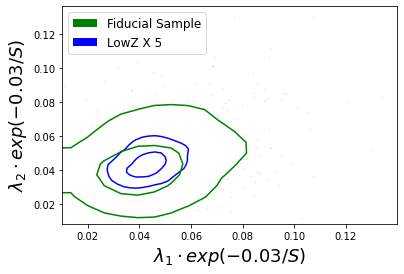

In [21]:
dd = np.loadtxt('chains/sims/q0aniso_sims_quad_exp_iso_trueCoord_NonZeroQuad_0_stat_only_lp200-post_equal_weights.dat')
dd5 = np.loadtxt('chains/sims/q0aniso_sims_quad_exp_iso_trueCoord_NonZeroQuad_4_stat_only_lp200-post_equal_weights.dat')


fac = np.exp(-0.03 / np.median(dd[:,-2]))
#fac3 = np.exp(-0.03 / np.median(dd3[:,-2]))
fac5 = np.exp(-0.03 / np.median(dd5[:,-2]))



corner.hist2d(dd5[:,-4] * fac5, dd5[:,-3] * fac5, smooth=1, levels=(1-np.exp(-0.5), 1 - np.exp(-2)), plot_density=False, color='b')
corner.hist2d(dd[:,-4] * fac, dd[:,-3] * fac, smooth=1, levels=(1-np.exp(-0.5), 1 - np.exp(-2)), plot_density=False, color='g')

#corner.hist2d(dd3[:,-4] * fac3, dd3[:,-3] * fac3, smooth=1, levels=(1-np.exp(-0.5), 1 - np.exp(-2)), plot_density=False, color='r')
#corner.hist2d(dd3[:,-4], dd3[:,-3], smooth=1, levels=(1-np.exp(-0.5), 1 - np.exp(-2)), plot_density=False, color='r')
#corner.hist2d(dd[:,-4], dd[:,-3], smooth=1, levels=(1-np.exp(-0.5), 1 - np.exp(-2)), plot_density=False, color='g')
#corner.hist2d(dd10[:,-4], dd10[:,-3], smooth=1, levels=(1-np.exp(-0.5), 1 - np.exp(-2)), plot_density=False, color='g')


plt.hist([], label='Fiducial Sample', color='g')
plt.hist([], label='LowZ X 5', color='b')

plt.xlabel('$\lambda_1 \cdot exp (-0.03 / S)$', fontsize=18)
plt.ylabel('$\lambda_2 \cdot exp (-0.03 / S)$', fontsize=18)
plt.legend(loc=0, prop={'size':12})
plt.savefig('plots/contour/sims/lowZtimes5_NonZeroQuad.png')

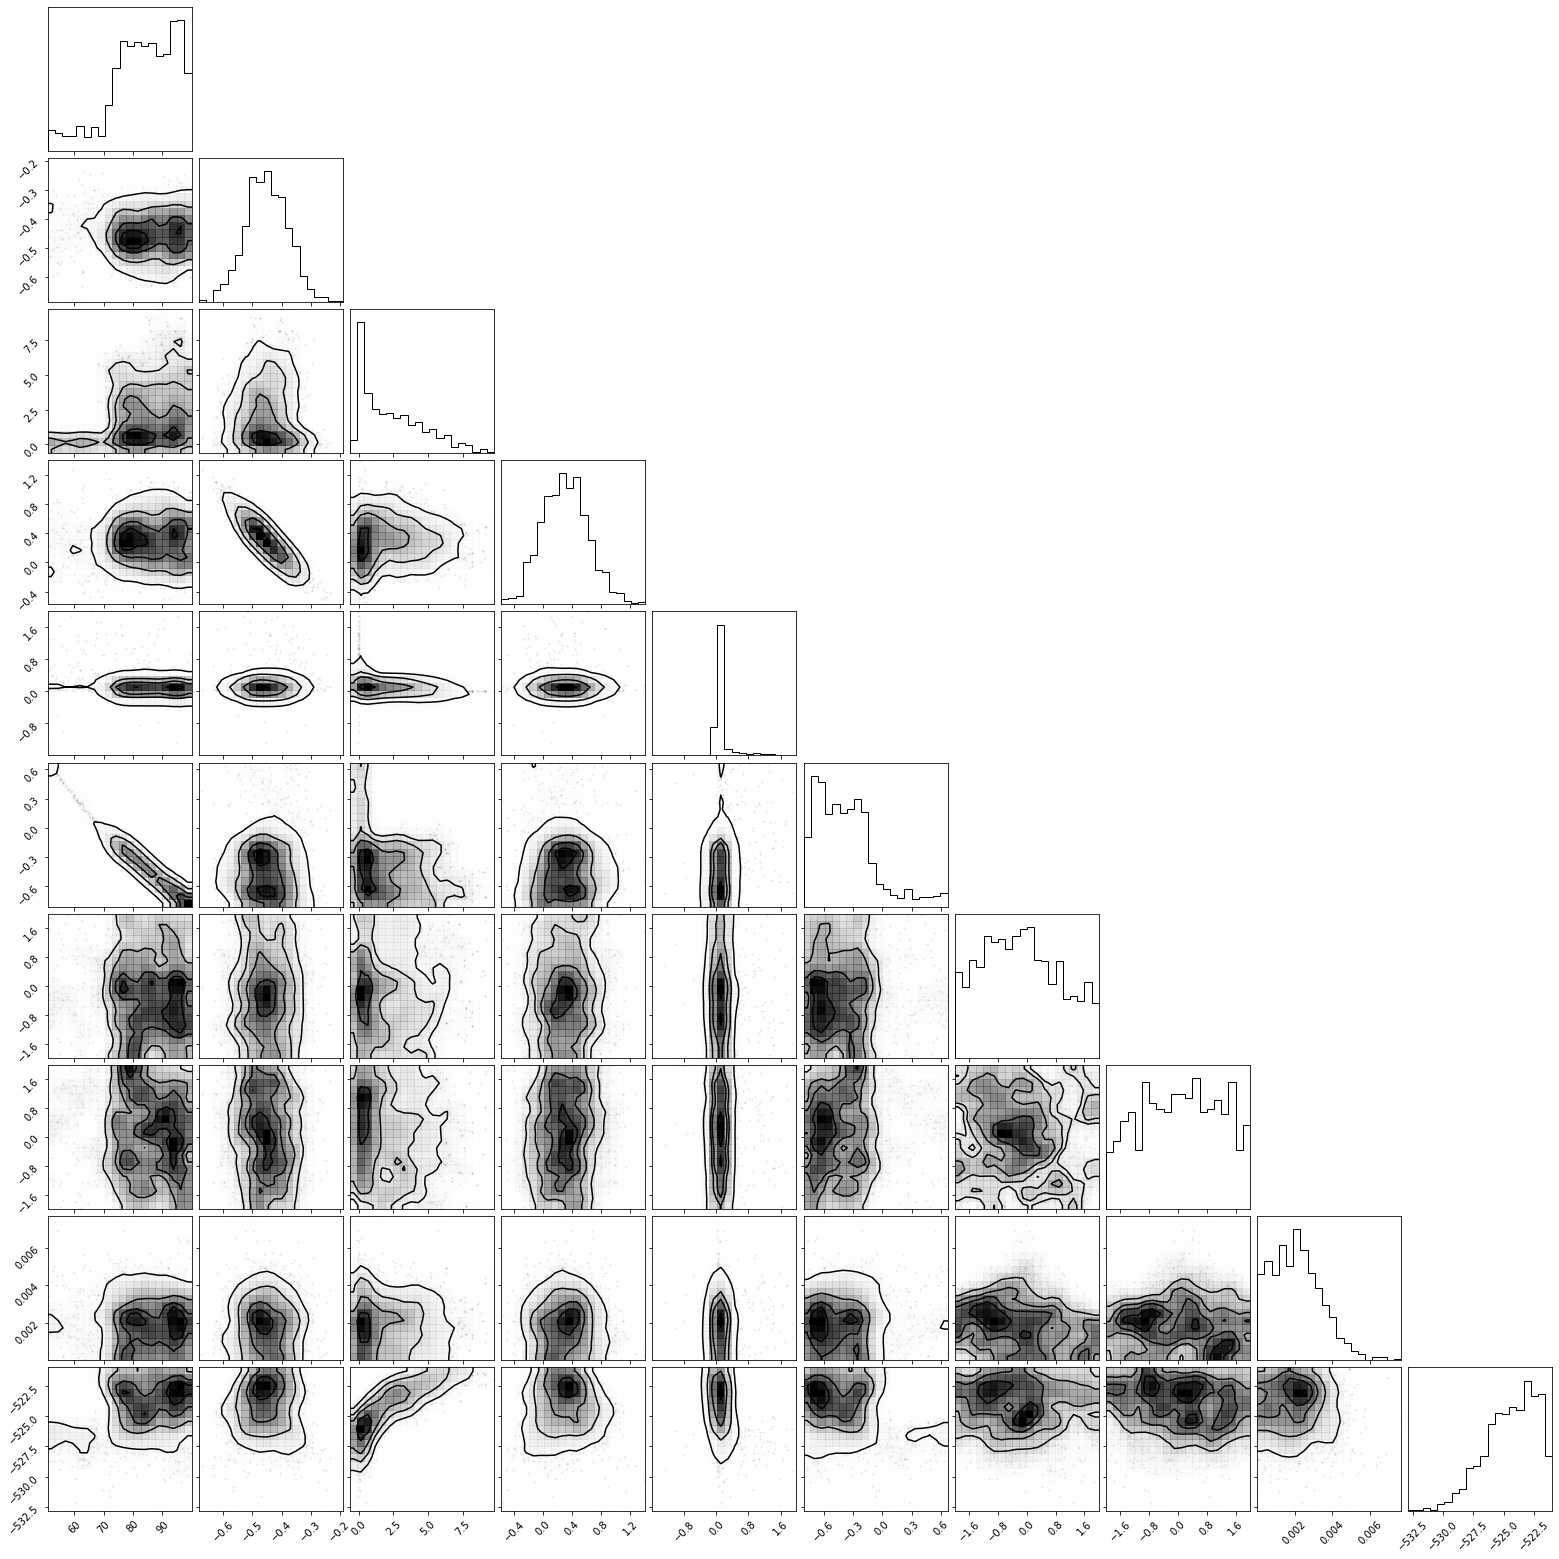

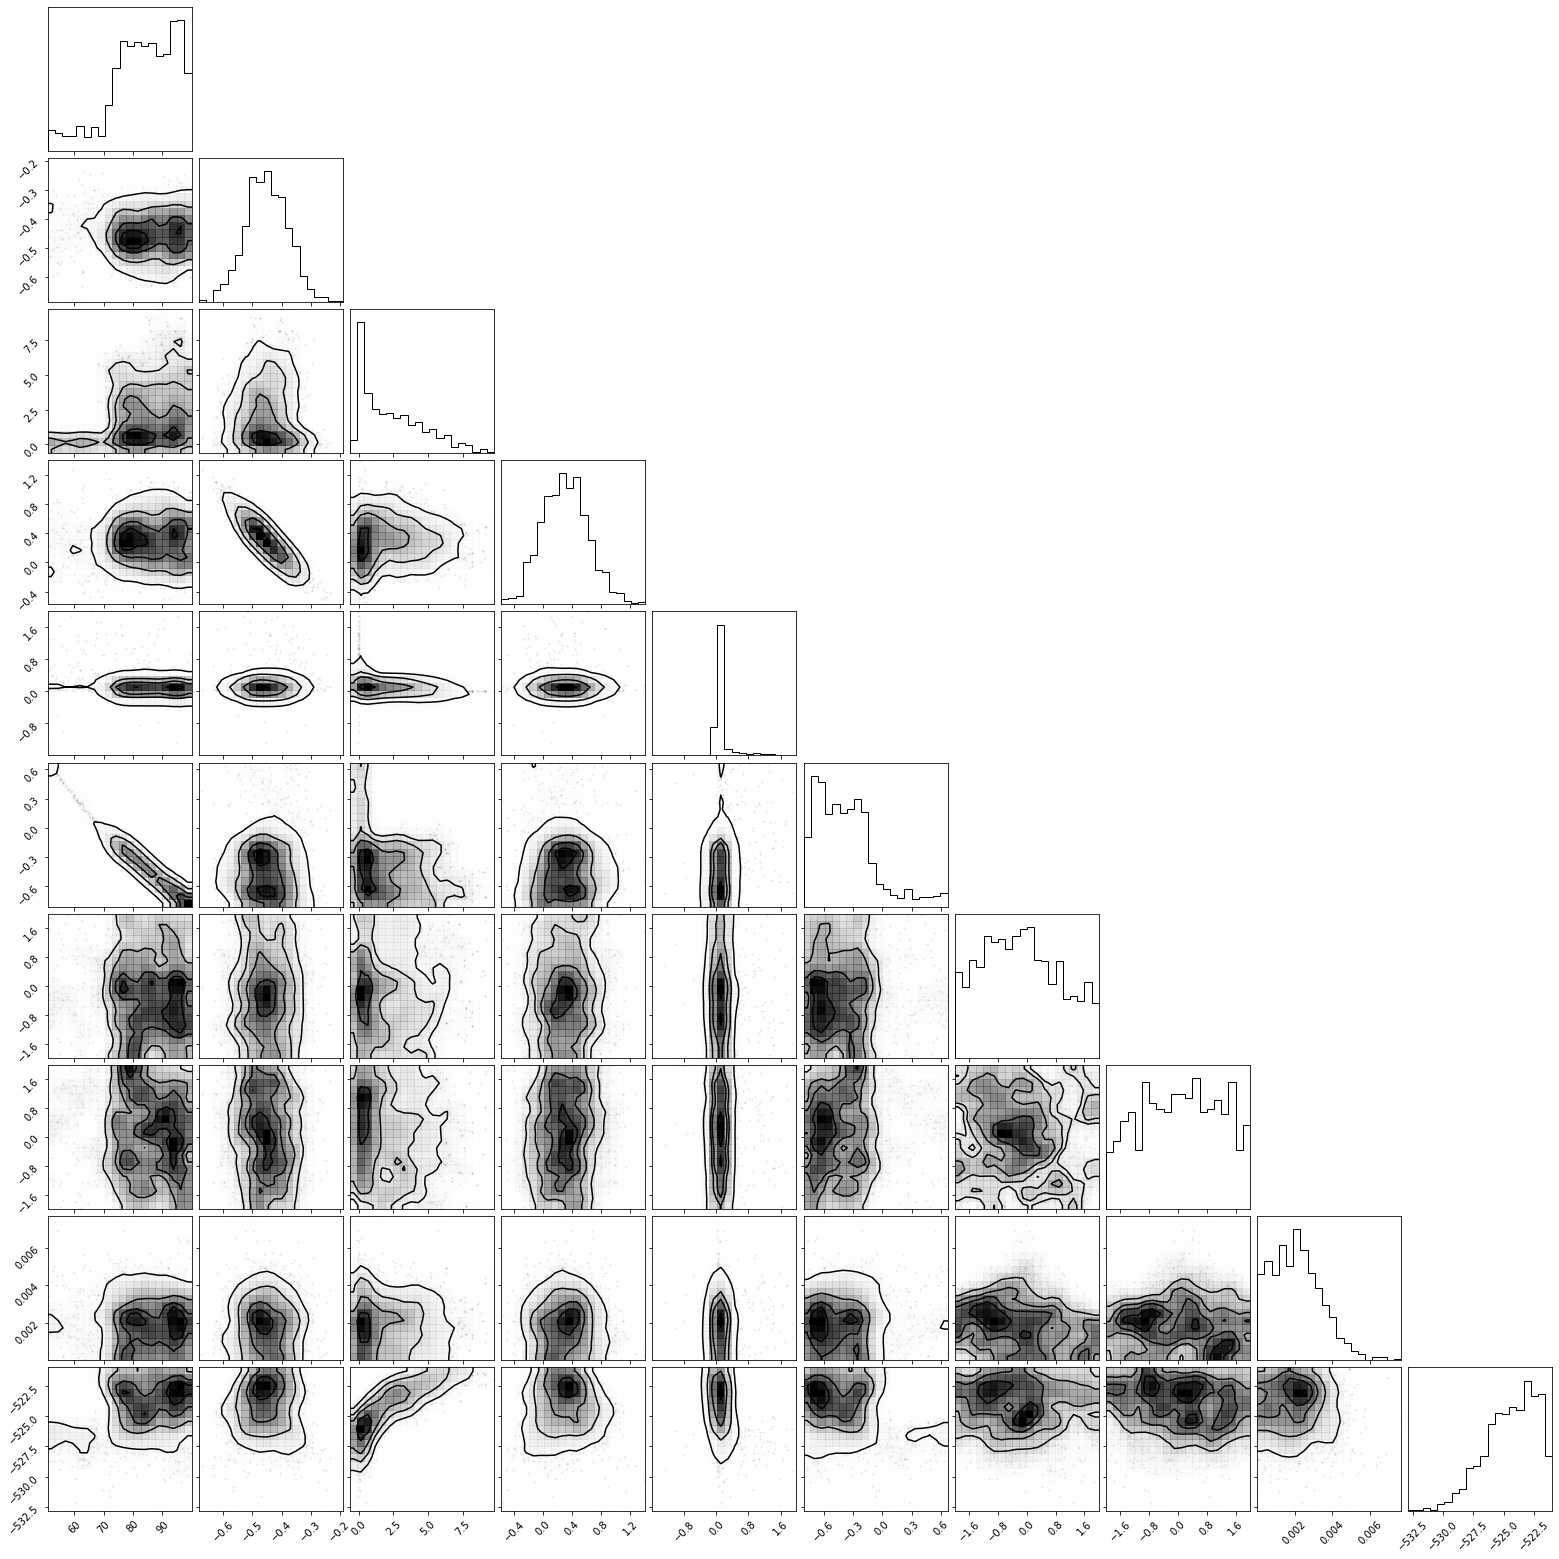